# Human Activity Recognition with Deep Learning

### 1. Overview
- [PAMAP2 Dataset](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring)
- Human Activity Recognition using Accelerometer worn on the Wrist

<img src="images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>Figure 1. Data Samples (Walking and Sitting)</div>

#### Import Libraries

In [1]:
from collections import Counter
from glob import glob
import os
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPool2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, normalize
%matplotlib inline

from visualize import plot_confusion_matrix

### 1. Preprocessing

#### A. Same as Machine Learning

In [2]:
filepaths = sorted(glob('data/PAMAP2/*.dat'))
filepaths

['data/PAMAP2/subject101.dat',
 'data/PAMAP2/subject102.dat',
 'data/PAMAP2/subject103.dat',
 'data/PAMAP2/subject104.dat',
 'data/PAMAP2/subject105.dat',
 'data/PAMAP2/subject106.dat',
 'data/PAMAP2/subject107.dat',
 'data/PAMAP2/subject108.dat',
 'data/PAMAP2/subject109.dat']

In [3]:
def most_common(l):
    """
    Find most common element in the list.
    
    Parameters
    ----------
    l : list
        list to find most common element
    
    Returns
    -------
    most common element
    """
    return Counter(l).most_common(1)[0][0]


def sliding_window(data, label, window_size, stride_size):
    """
    Apply sliding window to 2D array.
    Returns array of sliding windows.
    
    Parameters
    ----------
    data : array-like of shape (n_samples, num_features)
        X samples
    
    label : array-like of shape (n_samples,)
        y samples
    
    window_size : int
        Size of single window
    
    stride_size : int
        Space between windows
    
    Returns
    -------
    sliding_windows : array-like of shape (n_windows, window_size, num_features)
        Array of sliding windows

    labels : array-like of shape (n_windows,)
        Array of labels for each sliding window
    """
    sliding_windows, labels = [], []
    
    start = 0
    end = window_size
    
    while end < data.shape[0]:
        _data = data[start: end]
        _label = most_common(label[start: end])
        
        sliding_windows.append(_data)
        labels.append(_label)
        
        start += stride_size
        end += stride_size
    
    return np.array(sliding_windows), np.array(labels)

In [4]:
time_index = 0
label_index = 1
accelerometer_indices = {
    'hand': [4, 5, 6],
    'chest': [21, 22, 23],
    'ankle': [38, 39, 40],
}

label_map = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic walking',
    9: 'watching TV',
    10: 'computer work',
    11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    18: 'folding laundry',
    19: 'house cleaning',
    20: 'playing soccer',
    24: 'rope jumping',
    0: 'other (transient activities)',
}

In [5]:
sampling_rate = 50
window_size = int(2 * sampling_rate)
stride_size = int(1 * sampling_rate)

Xs, Ys, groups = [], [], []
for idx, filepath in enumerate(filepaths):
    # Load data
    df = pd.read_csv(filepath, delimiter=' ', header=None)

    # Select time, label, data columns
    time = df[time_index][::2]
    label = df[label_index][::2]
    label[label == 1] = 3
    label[label == 2] = 3
    label[label == 7] = 4
    label[label == 12] = 4
    label[label == 13] = 4
    data = df[accelerometer_indices['hand']][::2]
    
    # Drop rows with NaN values
    data = data.dropna(axis='index')
    
    # Sliding window
    X, Y = sliding_window(data, label, window_size, stride_size)
    
    # Drop "No Activity" samples
    mask = np.isin(Y, [3, 4, 5])
    X, Y = X[mask], Y[mask]
    
    # Add to Train/Test data
    Xs.append(X)
    Ys.append(Y)
    groups.append(np.full(X.shape[0], idx))

X = np.vstack(Xs)
Y = np.hstack(Ys)
groups = np.hstack(groups)
print(X.shape, Y.shape, groups.shape)

(13132, 100, 3) (13132,) (13132,)


In [6]:
set(Y)

{3, 4, 5}

#### B. Additional Processing for Deep Learning

##### 1) Label Mapping

In [7]:
labels = sorted(set(Y))
print('Before', labels)

Before [3, 4, 5]


In [8]:
map_label_dict = {label:index for index, label in enumerate(labels)}
unmap_label_dict = {index:label for index, label in enumerate(labels)}

map_label = np.vectorize(lambda label: map_label_dict[label])
unmap_label = np.vectorize(lambda index: unmap_label_dict[index])

Y = map_label(Y)
print('After', sorted(set(Y)))

After [0, 1, 2]


##### 2) Normalize

In [9]:
normalize_value = 9.8
X_normalized = X / normalize_value
print(X_normalized.shape)

(13132, 100, 3)


##### 3) Reshape

In [10]:
X_normalized = X_normalized[..., np.newaxis]
print(X_normalized.shape)

(13132, 100, 3, 1)


##### 4) One-Hot Encoding

In [11]:
num_classes = len(set(Y))
Y_categorical = to_categorical(Y, num_classes=num_classes)
print(Y_categorical.shape)

(13132, 3)


### 2. Model Definition and Training

#### A. Simple CNN

##### 1) Model Definition

In [12]:
num_features = 3
num_latent = 100
num_kernels = 16

model = Sequential([
    Input(shape=[window_size, num_features, 1]),
    # 100 x 3 x 1
    Conv2D(num_kernels, kernel_size=(5, 1), kernel_regularizer='l2'),
    # 96 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), strides=(4, 1), kernel_regularizer='l2'),
    # 23 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), strides=(3, 1), kernel_regularizer='l2'),
    # 7 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), strides=(2, 1), kernel_regularizer='l2'),
    # 2 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_latent, kernel_size=(2, 1), kernel_regularizer='l2'),
    # 1 x 3 x 100
    Flatten(),
    # 96
    Dense(num_classes, activation='softmax'),
    # 3
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 3, 16)         96        
_________________________________________________________________
re_lu (ReLU)                 (None, 96, 3, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 3, 16)         64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 3, 16)         1296      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 23, 3, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 3, 16)         64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 3, 16)          1

##### 2) Train / Test Split

In [13]:
test_subjects = [0]

test_mask = np.isin(groups, test_subjects)
train_mask = np.logical_not(test_mask)

X_train = X_normalized[train_mask]
Y_train = Y_categorical[train_mask]
X_test  = X_normalized[test_mask]
Y_test  = Y_categorical[test_mask]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(11460, 100, 3, 1) (11460, 3) (1672, 100, 3, 1) (1672, 3)


##### 3) Train Setup
<img src='images/optimizer.png' width=70% />

In [14]:
model.compile(
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    optimizer=RMSprop(learning_rate=0.001),
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses
    loss=CategoricalCrossentropy(),
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    metrics=['accuracy']
)

##### 4) Model Training

In [15]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10
)

Epoch 1/10
359/359 [==============================] - 3s 8ms/step - loss: 0.8290 - accuracy: 0.8991 - val_loss: 1.1370 - val_accuracy: 0.5724
Epoch 2/10
359/359 [==============================] - 3s 7ms/step - loss: 0.4675 - accuracy: 0.9276 - val_loss: 0.4010 - val_accuracy: 0.9103
Epoch 3/10
359/359 [==============================] - 3s 7ms/step - loss: 0.3500 - accuracy: 0.9336 - val_loss: 0.3812 - val_accuracy: 0.9205
Epoch 4/10
359/359 [==============================] - 3s 7ms/step - loss: 0.2954 - accuracy: 0.9363 - val_loss: 0.4044 - val_accuracy: 0.8953
Epoch 5/10
359/359 [==============================] - 3s 8ms/step - loss: 0.2690 - accuracy: 0.9366 - val_loss: 0.2689 - val_accuracy: 0.9228
Epoch 6/10
359/359 [==============================] - 3s 8ms/step - loss: 0.2509 - accuracy: 0.9375 - val_loss: 0.2645 - val_accuracy: 0.9306
Epoch 7/10
359/359 [==============================] - 3s 8ms/step - loss: 0.2441 - accuracy: 0.9370 - val_loss: 0.2774 - val_accuracy: 0.9127
Epoch 

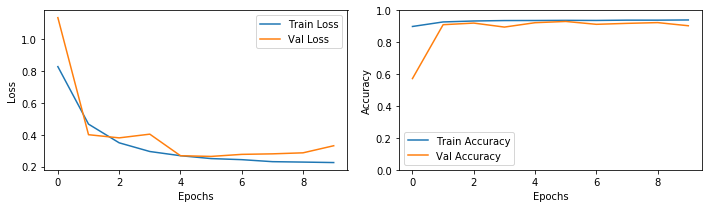

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

fig.tight_layout()
fig.show()

##### 5) Evaluation

In [17]:
Y_pred = model.predict(X_test)
print(Y_pred.shape, Y_test.shape)

(1672, 3) (1672, 3)


In [18]:
Y_pred_flatten, Y_test_flatten = np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1)
print(Y_pred_flatten.shape, Y_test_flatten.shape)

(1672,) (1672,)


              precision    recall  f1-score   support

    standing       0.85      0.95      0.90       724
     walking       0.95      0.85      0.90       735
     running       0.99      0.91      0.95       213

    accuracy                           0.90      1672
   macro avg       0.93      0.91      0.92      1672
weighted avg       0.91      0.90      0.90      1672



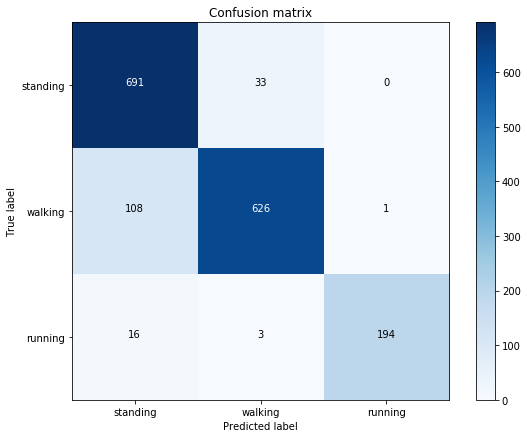

In [19]:
target_names = [label_map[label] for label in unmap_label(sorted(set(Y)))]
print(classification_report(Y_test_flatten, Y_pred_flatten, target_names=target_names))
plot_confusion_matrix(Y_test_flatten, Y_pred_flatten, target_names=target_names)

##### 6) TensorFlow Lite Model Convert and Save

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('har.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpa3um5ons/assets
